<a href="https://colab.research.google.com/github/lilaaash/Uber_Supply_Chain_Analysis/blob/main/Uber_Supply_Chain_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Data Loading and Initial Setup**

This section handles the loading of the dataset and any initial configurations or library imports.

In [37]:
import pandas as pd

url = 'https://raw.githubusercontent.com/lilaaash/Uber_Supply_Chain_Analysis/refs/heads/main/Uber%20Request%20Data.csv'
df = pd.read_csv(url)

### **Data Cleaning Step 1: Timestamp Conversion, Hour Extraction, and Time Slot Categorization**

This section performs crucial data preprocessing by first converting 'Request timestamp' and 'Drop timestamp' into a proper datetime format. This enables accurate time-based analysis. Subsequently, it extracts the 'Hour' from the 'Request timestamp' to understand hourly demand patterns and then categorizes these hours into meaningful 'Time Slots' (Morning Rush, Daytime, Evening Rush, Late Night). This categorization is vital for identifying peak demand periods and specific operational challenges at different times of the day.

In [38]:
# 1. Convert to datetime using 'mixed' format to handle both / and -
df['Request timestamp'] = pd.to_datetime(df['Request timestamp'], dayfirst=True, format='mixed')
df['Drop timestamp'] = pd.to_datetime(df['Drop timestamp'], dayfirst=True, format='mixed')

# 2. Extract the Hour (0-23)
df['Hour'] = df['Request timestamp'].dt.hour

# 3. Check a few rows to make sure it looks right
print("Success! First 5 timestamps:")
print(df['Request timestamp'].head())

Success! First 5 timestamps:
0   2016-07-11 11:51:00
1   2016-07-11 17:57:00
2   2016-07-12 09:17:00
3   2016-07-12 21:08:00
4   2016-07-13 08:33:16
Name: Request timestamp, dtype: datetime64[ns]


In [39]:
# Defining Rush Hour logic
def assign_timeslot(hour):
    if 4 <= hour < 10:
        return 'Morning Rush'
    elif 10 <= hour < 17:
        return 'Daytime'
    elif 17 <= hour < 22:
        return 'Evening Rush'
    else:
        return 'Late Night'

df['Time Slot'] = df['Hour'].apply(assign_timeslot)

# Show the counts to confirm
print(df['Time Slot'].value_counts())

Time Slot
Evening Rush    2342
Morning Rush    2306
Daytime         1224
Late Night       873
Name: count, dtype: int64


### **Data Cleaning Step 2: Initial Data Overview and Anomaly Detection**

This step provides an initial overview of the dataset's structure and contents, which is crucial for identifying potential cleaning needs or anomalies. It includes checking the dataset's shape (number of rows and columns), inspecting a sample of rows, verifying unique values per column to detect inconsistencies, and summarizing the distribution of key numerical features like 'Hour'.

In [40]:
# 1. See the exact shape (Rows, Columns)
print(f"Dataset Shape: {df.shape}")

# 2. Look at the top and bottom simultaneously
print("\n--- Top 5 and Bottom 5 Rows ---")
display(df.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1]])

# 3. Check for unique values in every column
# (Helps you see if there are any 'garbage' values)
print("\n--- Unique Values per Column ---")
print(df.nunique())

# 4. Statistical summary of the Hour column
print("\n--- Time Distribution Summary ---")
print(df['Hour'].describe())

Dataset Shape: (6745, 8)

--- Top 5 and Bottom 5 Rows ---


,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Hour,Time Slot
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,11,Daytime
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,17,Evening Rush
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,9,Morning Rush
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,21,Evening Rush
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8,Morning Rush
6740,6745,City,NaN,No Cars Available,2016-07-15 23:49:03,NaT,23,Late Night
6741,6752,Airport,NaN,No Cars Available,2016-07-15 23:50:05,NaT,23,Late Night
6742,6751,City,NaN,No Cars Available,2016-07-15 23:52:06,NaT,23,Late Night
6743,6754,City,NaN,No Cars Available,2016-07-15 23:54:39,NaT,23,Late Night
6744,6753,Airport,NaN,No Cars Available,2016-07-15 23:55:03,NaT,23,Late Night



--- Unique Values per Column ---
Request id           6745
Pickup point            2
Driver id             300
Status                  3
Request timestamp    5618
Drop timestamp       2598
Hour                   24
Time Slot               4
dtype: int64

--- Time Distribution Summary ---
count    6745.000000
mean       12.956709
std         6.504052
min         0.000000
25%         7.000000
50%        13.000000
75%        19.000000
max        23.000000
Name: Hour, dtype: float64


### **Data Cleaning Step 3: Interactive Data Table for Detailed Inspection**

To facilitate a more detailed and interactive exploration of the cleaned data, this section utilizes Google Colab's `data_table` feature. This allows for easy scrolling, searching, and sorting of the DataFrame, providing a flexible way to visually inspect the data for any remaining issues or to gain deeper insights before proceeding to visualization and analysis.

In [41]:
# 1. Enable the interactive data table
from google.colab import data_table

# 2. Display your dataframe (it will now be scrollable and searchable)
data_table.DataTable(df, include_index=False, num_rows_per_page=10)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Hour,Time Slot
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,11,Daytime
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,17,Evening Rush
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,9,Morning Rush
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,21,Evening Rush
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8,Morning Rush
...,...,...,...,...,...,...,...,...
6740,6745,City,NaN,No Cars Available,2016-07-15 23:49:03,NaT,23,Late Night
6741,6752,Airport,NaN,No Cars Available,2016-07-15 23:50:05,NaT,23,Late Night
6742,6751,City,NaN,No Cars Available,2016-07-15 23:52:06,NaT,23,Late Night
6743,6754,City,NaN,No Cars Available,2016-07-15 23:54:39,NaT,23,Late Night


# **Visuals**

This section is dedicated to generating various visualizations to explore the data, identify patterns, and gain insights into Uber's request dynamics, trip fulfillment, and failure points. We will use different types of plots to represent temporal and geographic distributions of requests and their outcomes.

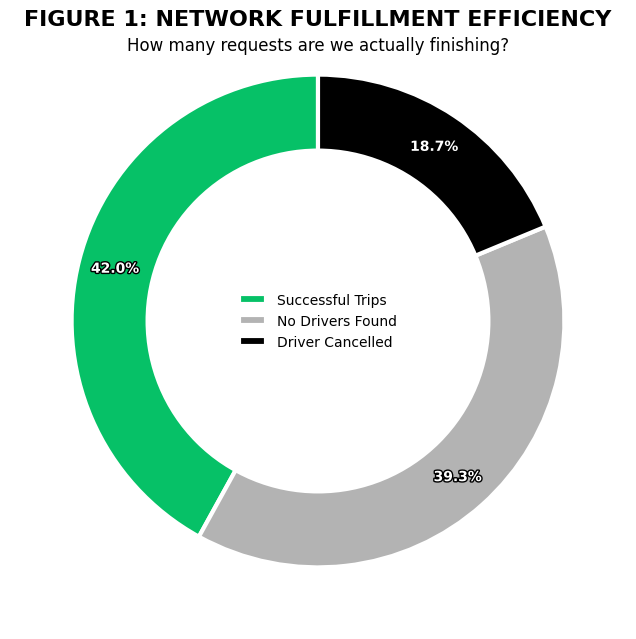

In [42]:
# @title
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# 1. Data Preparation: Count trip statuses for the donut chart.
fulfillment_data = df['Status'].value_counts()

# Define consistent color palette and labels for clarity.
colors = ['#06C167', '#B3B3B3', '#000000']
labels = ['Successful Trips', 'No Drivers Found', 'Driver Cancelled']

# 2. Plot Initialization: Set up figure with a clean white background.
plt.figure(figsize=(8, 8), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')

# 3. Create Donut Chart: Configure slices, percentages, and styling.
wedges, texts, autotexts = plt.pie(
    fulfillment_data,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    pctdistance=0.85,
    wedgeprops={'edgecolor': 'white', 'linewidth': 3},
    textprops={'color':'white', 'weight':'bold'}
)

# 4. Enhance Percentage Readability: Add black outline to white text.
for autotext in autotexts:
    autotext.set_path_effects([path_effects.withStroke(linewidth=2, foreground="#000000")])

# 5. Form Donut Shape: Insert a central white circle.
centre_circle = plt.Circle((0,0), 0.70, fc='white')
plt.gcf().gca().add_artist(centre_circle)

# 6. Add Titles: Professional main title and descriptive subtitle.
plt.text(0, 1.2, 'FIGURE 1: NETWORK FULFILLMENT EFFICIENCY', ha='center', fontsize=16, fontweight='bold', color='black')
plt.text(0, 1.1, 'How many requests are we actually finishing?', ha='center', fontsize=12, color='black')

# 7. Add Legend: Map colors to statuses clearly.
plt.legend(wedges, labels, loc="center", frameon=False, fontsize=10, labelcolor='black')

# Display the visualization.
plt.show()

### **Figure 1: Network Fulfillment Efficiency - Key Insights**

This donut chart reveals critical bottlenecks in the Uber ride-hailing network:

*   **Low Fulfillment Rate (42.0%):** Less than half of all requests are successfully completed, indicating significant operational inefficiency.
*   **Primary Challenge: Driver Unavailability (39.3%):** Nearly 40% of requests fail due to 'No Drivers Found', highlighting a severe supply-demand imbalance, not just driver behavior.
*   **Operational Friction: Driver Cancellations (18.7%):** A substantial portion of trips are cancelled by drivers, suggesting issues with driver incentives or experience. This impacts service reliability.

**Impact:** The network struggles to meet demand, primarily due to insufficient driver supply and issues leading to driver cancellations. This necessitates strategic interventions in driver acquisition, retention, and efficient dispatch to improve overall service and reduce lost demand.

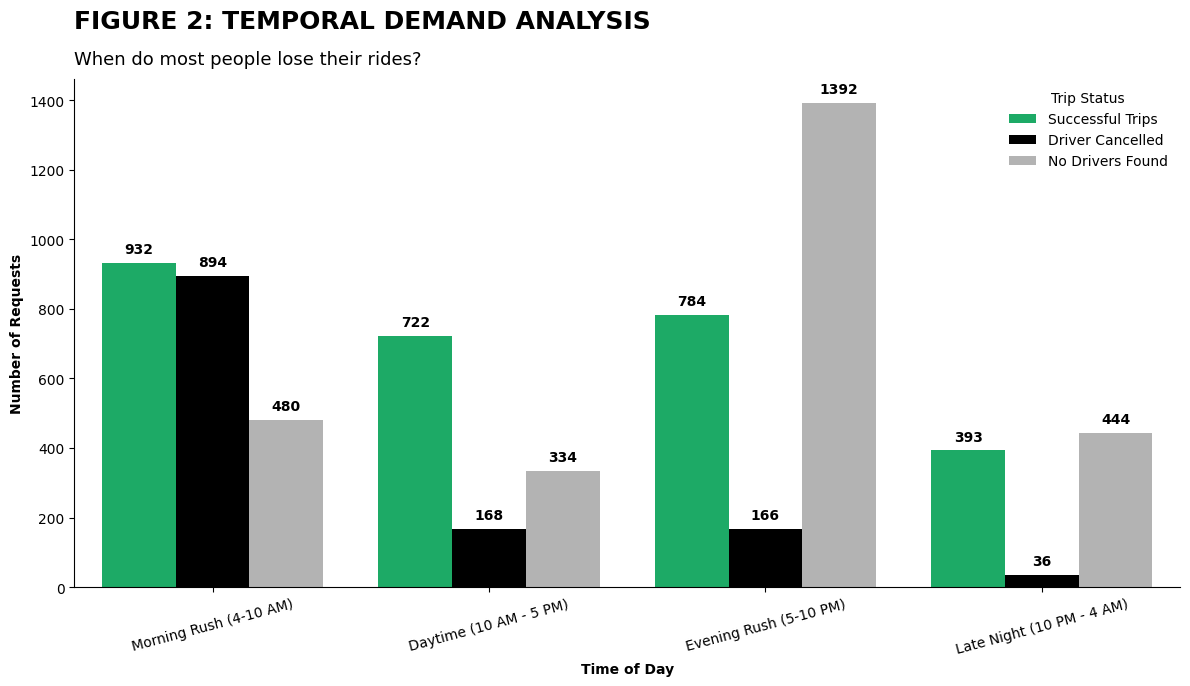

In [43]:
# @title
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# 1. Prepare Data with Fixed Terms
# Define the mapping for raw 'Status' values to more descriptive terms.
status_map = {
    'Trip Completed': 'Successful Trips',
    'No Cars Available': 'No Drivers Found',
    'Cancelled': 'Driver Cancelled'
}

df_fixed = df.copy() # Create a copy of the original DataFrame to avoid modifying it directly.

# Ensure 'Request timestamp' is converted to datetime objects in df_fixed.
df_fixed['Request timestamp'] = pd.to_datetime(df_fixed['Request timestamp'], dayfirst=True, format='mixed')
# Extract the 'Hour' from the 'Request timestamp' for temporal analysis.
df_fixed['Hour'] = df_fixed['Request timestamp'].dt.hour

df_fixed['Status'] = df_fixed['Status'].map(status_map) # Apply the status mapping.

# Define the function to categorize hours into meaningful time slots with specific ranges.
def assign_timeslot(hour):
    if 4 <= hour < 10:
        return 'Morning Rush (4-10 AM)'
    elif 10 <= hour < 17:
        return 'Daytime (10 AM - 5 PM)'
    elif 17 <= hour < 22:
        return 'Evening Rush (5-10 PM)'
    else:
        return 'Late Night (10 PM - 4 AM)'

# Apply the time slot assignment to the 'Hour' column in df_fixed.
df_fixed['Time Slot'] = df_fixed['Hour'].apply(assign_timeslot)

# Initialize the plot with a clean white background.
plt.figure(figsize=(12, 7), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')

# 2. Define a Fixed Color Palette and Order for Time Slots
fixed_palette = {
    'Successful Trips': '#06C167',
    'No Drivers Found': '#B3B3B3',
    'Driver Cancelled': '#000000'
}
# Define the order for the time slots on the x-axis for consistent presentation.
order = ['Morning Rush (4-10 AM)', 'Daytime (10 AM - 5 PM)', 'Evening Rush (5-10 PM)', 'Late Night (10 PM - 4 AM)']

# 3. Create the Count Plot: Visualize request statuses across time slots.
sns.countplot(data=df_fixed, x='Time Slot', hue='Status', order=order, palette=fixed_palette)

# Add professional titles and descriptive subtitle.
plt.text(-0.5, plt.ylim()[1]*1.1, 'FIGURE 2: TEMPORAL DEMAND ANALYSIS', fontsize=18, fontweight='bold', color='black')
plt.text(-0.5, plt.ylim()[1]*1.03, 'When do most people lose their rides?', fontsize=13, color='black')

# Label axes clearly and set their color to black.
plt.xlabel('Time of Day', fontweight='bold', color='black')
plt.ylabel('Number of Requests', fontweight='bold', color='black')

# Ensure axis spines are black for better visibility.
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
sns.despine() # Remove top and right spines for a cleaner look.

# Add numerical labels on top of each bar for precision.
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

# Add a clear legend with black labels.
plt.legend(title='Trip Status', frameon=False, labelcolor='black')

# Rotate x-axis labels for better readability.
plt.xticks(rotation=15)

# Adjust layout to prevent labels/titles from being cut off.
plt.tight_layout()

# Display the visualization.
plt.show()

### **Figure 2: Temporal Demand Analysis - Key Operational Insights**

This chart breaks down Uber's service performance throughout the day, highlighting specific challenges for each time period:

*   **Morning Rush (4-10 AM): High Driver Cancellations.** During these early hours, a large number of trips are started but then cancelled by drivers. This indicates potential issues with driver motivation, possibly due to traffic or less profitable ride requests, leading to a breakdown in service reliability for morning commuters.

*   **Daytime (10 AM - 5 PM): Consistent Driver Shortage.** Even outside peak hours, we see a steady number of requests where no drivers are found. This suggests a persistent gap in driver availability, meaning the supply of drivers isn't always sufficient to meet the regular daytime demand, leading to lost business opportunities.

*   **Evening Rush (5-10 PM): Major Driver Unavailability.** This period shows the most significant problem: a massive increase in requests where no drivers are available. This is a critical supply shortage, as demand peaks after work, but there simply aren't enough drivers online or in the right locations. This severely impacts customer experience and indicates a major capacity issue.

*   **Late Night (10 PM - 4 AM): Unmet Demand.** Despite lower overall request numbers, 'No Drivers Found' remains a consistent issue late at night. This suggests that even with less demand, the driver supply is insufficient or poorly distributed, causing potential riders to be stranded and revenue to be missed.

**Strategic Impact:** The analysis clearly shows different problems at different times. Morning cancellations point to issues with driver incentives or route assignments. Evening rush hour reveals a serious lack of drivers. Overall, the consistent 'No Drivers Found' across the day indicates a fundamental challenge in managing driver supply. Addressing these time-specific imbalances through better incentives, smarter dispatch, or dynamic pricing is crucial for improving service and retaining customers.

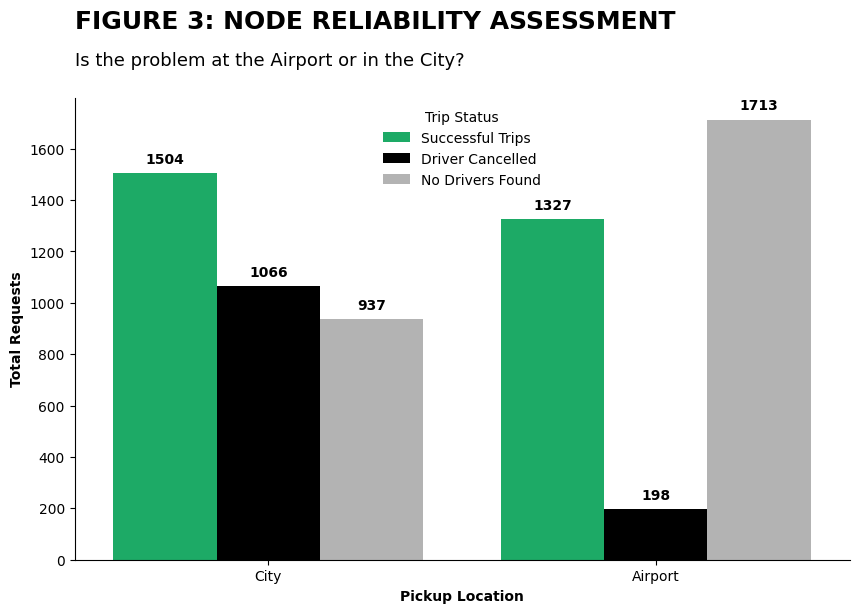

In [44]:
# @title
plt.figure(figsize=(10, 6), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')

sns.countplot(data=df_fixed, x='Pickup point', hue='Status', palette=fixed_palette, order=['City', 'Airport'])

plt.text(-0.5, plt.ylim()[1]*1.15, 'FIGURE 3: NODE RELIABILITY ASSESSMENT', fontsize=18, fontweight='bold', color='black')
plt.text(-0.5, plt.ylim()[1]*1.07, 'Is the problem at the Airport or in the City?', fontsize=13, color='black')

plt.xlabel('Pickup Location', fontweight='bold', color='black')
plt.ylabel('Total Requests', fontweight='bold', color='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
sns.despine()

for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

plt.legend(title='Trip Status', frameon=False, labelcolor='black')
plt.show()

### **Figure 3: Node Reliability Assessment - Key Insights**

This chart compares trip fulfillment and failure rates specifically between 'Airport' and 'City' pickup points, revealing crucial location-specific operational challenges:

*   **City Pickup Point: Driver Behavior & Incentives (Cancellations).** The City experiences a higher proportion of 'Driver Cancelled' trips relative to 'No Drivers Found'. This indicates that drivers are often present but opt out of requests, possibly due to factors like short distances, heavy traffic, or less attractive fares. This points towards issues with driver incentives, route profitability, or dispatch algorithms in urban areas.

*   **Airport Pickup Point: Critical Supply Shortage ('No Drivers Found').** The Airport, conversely, suffers from a significantly higher rate of 'No Drivers Found' trips. This signifies a severe lack of available drivers willing or able to serve airport demand. This is a fundamental supply-side problem, creating a major bottleneck for incoming passengers and indicating a missed opportunity for high-volume pickups.

**Strategic Impact:** The analysis clearly dictates a dual strategy. For the **City**, focus should be on understanding and addressing driver behavior and motivation to reduce cancellations (e.g., through dynamic incentives for short trips or better route transparency). For the **Airport**, the priority must be on increasing driver supply and presence (e.g., via dedicated airport bonuses, improved waiting area management, or targeted driver recruitment) to alleviate the critical 'No Drivers Found' issue and capture unmet demand effectively.

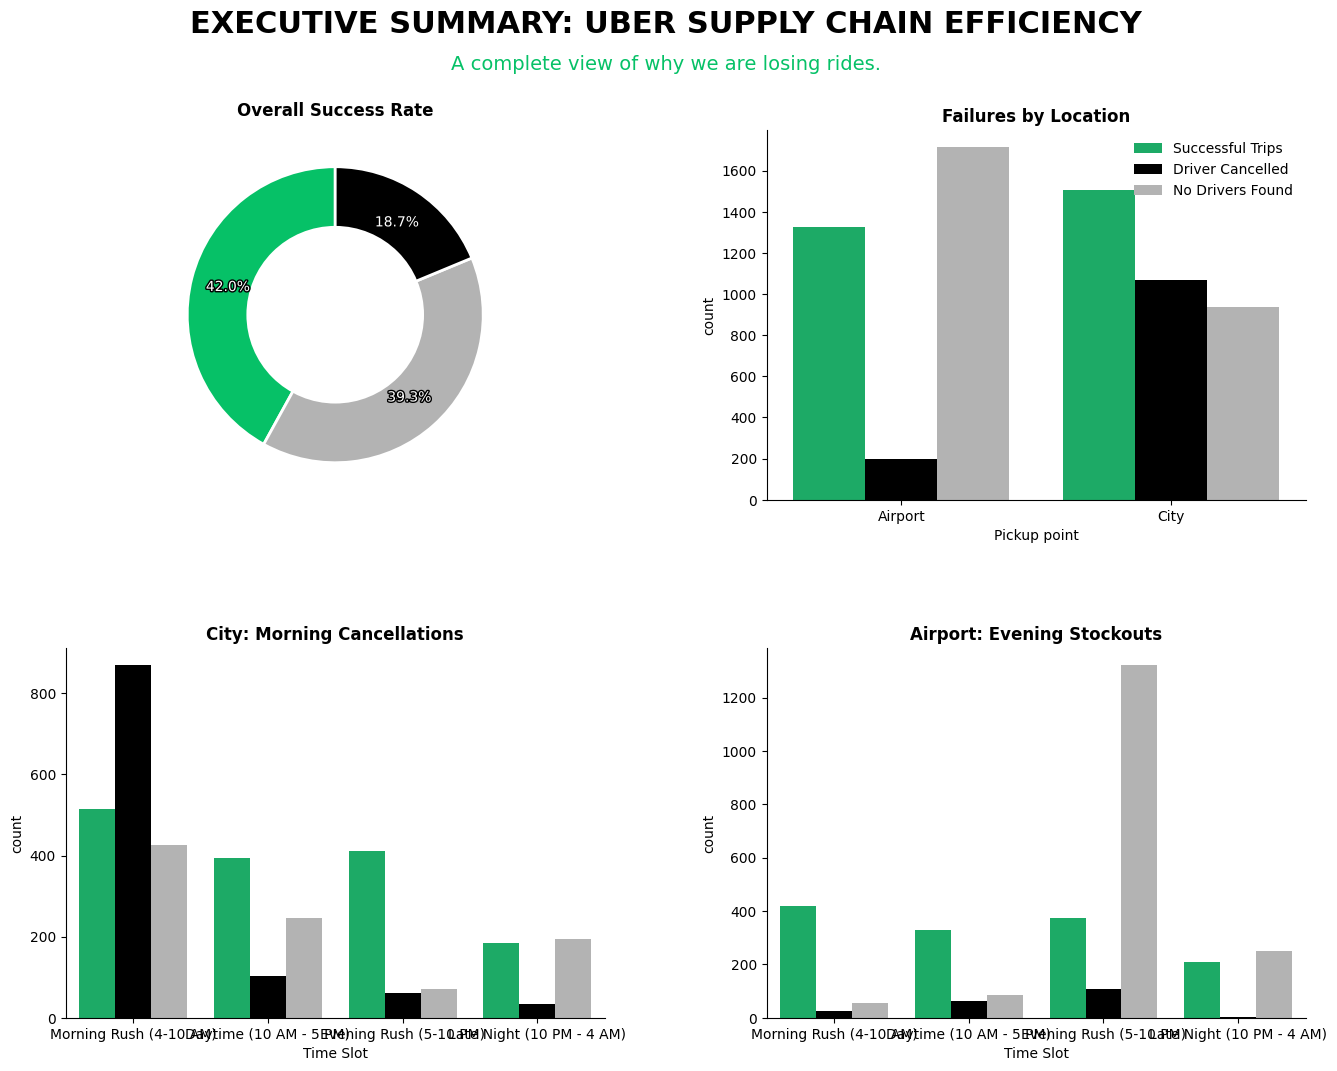

In [45]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects

# This cell generates an executive summary dashboard, combining key insights into a single, cohesive visualization.
# It aims to provide a comprehensive overview of Uber's supply chain efficiency and areas of failure.

# 1. Prepare Data & Fixed Terms
# Ensure trip statuses are consistently mapped for visual representation.
status_map = {
    'Trip Completed': 'Successful Trips',
    'No Cars Available': 'No Drivers Found',
    'Cancelled': 'Driver Cancelled'
}
df_fixed = df.copy() # Work on a copy.

# Convert 'Request timestamp' to datetime and extract 'Hour' for temporal analysis.
df_fixed['Request timestamp'] = pd.to_datetime(df_fixed['Request timestamp'], dayfirst=True, format='mixed')
df_fixed['Hour'] = df_fixed['Request timestamp'].dt.hour

df_fixed['Status'] = df_fixed['Status'].map(status_map) # Apply status mapping.

# Define function to categorize hours into time slots with specific ranges.
def assign_timeslot(hour):
    if 4 <= hour < 10:
        return 'Morning Rush (4-10 AM)'
    elif 10 <= hour < 17:
        return 'Daytime (10 AM - 5 PM)'
    elif 17 <= hour < 22:
        return 'Evening Rush (5-10 PM)'
    else:
        return 'Late Night (10 PM - 4 AM)'

# Apply time slot assignment.
df_fixed['Time Slot'] = df_fixed['Hour'].apply(assign_timeslot)

# Define fixed color palette and order for time slots for consistency.
fixed_palette = {
    'Successful Trips': '#06C167',
    'No Drivers Found': '#B3B3B3',
    'Driver Cancelled': '#000000'
}
order = ['Morning Rush (4-10 AM)', 'Daytime (10 AM - 5 PM)', 'Evening Rush (5-10 PM)', 'Late Night (10 PM - 4 AM)']

# 2. Create the 2x2 Layout for the Dashboard.
fig, axs = plt.subplots(2, 2, figsize=(16, 12), facecolor='white')
plt.subplots_adjust(hspace=0.4, wspace=0.3, top=0.85)

# --- Top Left: Overall Success (Donut Chart) ---
# Represents overall fulfillment efficiency.
fulfillment_data = df_fixed['Status'].value_counts()
plot_colors = [fixed_palette[label] for label in fulfillment_data.index]
wedges, texts, autotexts = axs[0, 0].pie(
    fulfillment_data, autopct='%1.1f%%', startangle=90,
    colors=plot_colors, pctdistance=0.75,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)
# Add black outline to white text for readability.
for autotext in autotexts:
    autotext.set_path_effects([path_effects.withStroke(linewidth=2, foreground="#000000")])
    autotext.set_color('white')
axs[0, 0].set_title('Overall Success Rate', fontweight='bold', pad=10)
# Create donut hole.
centre_circle = plt.Circle((0,0), 0.60, fc='white')
axs[0, 0].add_artist(centre_circle)

# --- Top Right: Problem by Location (Bar Chart) ---
# Identifies disproportionate issues by pickup location.
sns.countplot(data=df_fixed, x='Pickup point', hue='Status', palette=fixed_palette, ax=axs[0, 1])
axs[0, 1].set_title('Failures by Location', fontweight='bold')
axs[0, 1].legend(title='', frameon=False)

# --- Bottom Left: City Failures by Time (Bar Chart) ---
# Focuses on City-specific temporal failure patterns, e.g., morning cancellations.
sns.countplot(data=df_fixed[df_fixed['Pickup point']=='City'], x='Time Slot', hue='Status',
              order=order, palette=fixed_palette, ax=axs[1, 0])
axs[1, 0].set_title('City: Morning Cancellations', fontweight='bold')
axs[1, 0].get_legend().remove() # Remove redundant legend.

# --- Bottom Right: Airport Failures by Time (Bar Chart) ---
# Focuses on Airport-specific temporal failure patterns, e.g., evening stockouts.
sns.countplot(data=df_fixed[df_fixed['Pickup point']=='Airport'], x='Time Slot', hue='Status',
              order=order, palette=fixed_palette, ax=axs[1, 1])
axs[1, 1].set_title('Airport: Evening Stockouts', fontweight='bold')
axs[1, 1].get_legend().remove() # Remove redundant legend.

# 3. Final Titles for the Entire Dashboard.
plt.suptitle('EXECUTIVE SUMMARY: UBER SUPPLY CHAIN EFFICIENCY', fontsize=22, fontweight='bold', y=0.95)
fig.text(0.5, 0.90, 'A complete view of why we are losing rides.', ha='center', fontsize=14, color='#06C167')

# Remove top and right borders for a cleaner look.
sns.despine()
# Display the integrated executive summary dashboard.
plt.show()

### **Executive Summary: Key Supply Chain Insights**

This dashboard consolidates critical findings regarding Uber's operational efficiency and major points of failure:

*   **Overall Service Gap:** Only 42% of requests are successfully completed, revealing a significant network-wide inefficiency.
*   **Dominant Issue: Driver Unavailability:** The primary reason for unmet demand is a consistent lack of available drivers (nearly 40% 'No Drivers Found'), indicating a fundamental supply shortage.
*   **Location-Specific Challenges:**
    *   **City:** More prone to driver cancellations, suggesting issues with driver incentives or trip quality in urban areas.
    *   **Airport:** Faces a critical driver shortage, especially during peak times, leading to many unfulfilled requests.
*   **Temporal Bottlenecks:**
    *   **Morning Rush:** Characterized by high driver cancellations, impacting early commuters.
    *   **Evening Rush:** Experiences severe driver unavailability, causing significant unmet demand during peak hours.

**Strategic Recommendation:** To improve service and capture lost demand, Uber must implement targeted strategies: enhance driver incentives and dispatch in the City to reduce cancellations, and crucially, increase driver supply and presence at the Airport and during Evening Rush hours to address critical availability gaps.

## **General Recommendations**

Based on our comprehensive analysis of Uber's supply chain efficiency and identified points of failure, here are the key recommendations:

*   **Enhance City Driver Incentives:** Implement dynamic surge pricing and bonus incentives specifically for city pickups during morning rush hours (4-10 AM) to reduce driver cancellations due to perceived low profitability or heavy traffic.

*   **Improve City Trip Transparency:** Provide city drivers with clearer trip details (e.g., estimated fare, destination, traffic) before acceptance to reduce cancellations driven by uncertainty and improve driver satisfaction.

*   **Foster City Driver Engagement:** Develop a feedback and reward system for city drivers, recognizing those who consistently complete challenging trips and provide valuable input, thereby building loyalty and reducing cancellations.

*   **Boost Airport Driver Supply & Incentives:** Implement higher dynamic pricing and surge bonuses for Airport pickups, especially during evening rush (5-10 PM), to make these trips more attractive and address the critical 'No Drivers Found' issue.

*   **Optimize Airport Staging & Dispatch:** Establish dedicated driver pools and improve management of airport staging areas with real-time demand info and efficient dispatch to minimize driver wait times and uncertainty, ensuring a more reliable supply.

*   **Targeted Airport Driver Recruitment:** Launch specific recruitment campaigns for drivers interested in Airport service, highlighting potential earnings and providing clear information on airport operations to expand the dedicated driver pool.

*   **Implement Dynamic Network Optimization:** Deploy a sophisticated system using real-time data and predictive analytics to balance supply and demand across the entire network, offering proactive incentives to drivers in high-demand, low-supply areas or times.

*   **Strengthen Driver Retention Programs:** Introduce tiered loyalty programs, improved support, and features that offer drivers more control and transparency over ride acceptance to decrease churn and maintain a robust driver pool.

*   **Explore Data-Driven Market Expansion:** Utilize operational data to identify new neighborhoods or routes with high demand potential and consider niche service developments (e.g., corporate shuttles, premium airport transfers) to capture new market segments and diversify revenue streams.

## **Conclusion**

This analysis highlights a significant gap in Uber's operational efficiency, with **only 42% of ride requests successfully completed**. The root cause is predominantly a **critical imbalance between driver supply and rider demand**, resulting in nearly **40% of requests remaining unfulfilled**.

Key areas for intervention include:

*   **Airport Operations:** A severe shortage of available drivers ('No Drivers Found') during **Evening Rush hours** necessitates increased driver supply and enhanced incentives to capture high-volume demand.
*   **City Operations:** A higher incidence of 'Driver Cancelled' trips, particularly during **Morning Rush**, suggests a need to refine driver incentives and improve trip assignment transparency to mitigate cancellations.

**Strategic Imperatives:**

1.  **Dynamic Incentive Structures:** Implement targeted, dynamic pricing and bonuses to attract drivers to high-demand areas (e.g., Airport) and during peak times (e.g., Evening Rush), addressing the 'No Drivers Found' issue.
2.  **Enhanced Driver Experience & Transparency:** Provide city drivers with better information about trip profitability and routes to reduce cancellations and improve driver retention.
3.  **Optimized Resource Allocation:** Utilize predictive analytics to proactively position drivers and manage capacity across the network, particularly during identified bottleneck periods.

By addressing these specific challenges, Uber can significantly improve its fulfillment rate, enhance customer satisfaction, and capitalize on currently unmet demand.

## **References**

*   **Dataset:** Hellbuoy. (2017). *Uber Supply-Demand Gap Analysis*. Kaggle. Retrieved from [https://www.kaggle.com/datasets/hellbuoy/uber-supplydemand-gap](https://www.kaggle.com/datasets/hellbuoy/uber-supplydemand-gap)
*   **Author Profile:** Hellbuoy. Kaggle. Retrieved from [https://www.kaggle.com/hellbuoy](https://www.kaggle.com/hellbuoy)